# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import *

import numpy as np

np.set_printoptions(precision = 4)

data_base_dir = "./data"
output_base_dir = "./output"

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Computing camera calibration using chessboard images

In [2]:
from transformation import get_camera_calibration_matrix

ret, cameraMatrix, distCoeffs, rvecs, tvecs =\
                                get_camera_calibration_matrix(6, 9,
                                                              data_base_dir + "/camera_calibration",
                                                              visualize = False)

print("ret:                ", ret)
print("cameraMatrix.shape: ", cameraMatrix.shape)
print("distCoeffs.shape:   ", distCoeffs.shape)
print("len(rvecs):         ", len(rvecs))
print("len(tvecs):         ", len(tvecs))

ret:                 103.11308649883414
cameraMatrix.shape:  (3, 3)
distCoeffs.shape:    (1, 5)
len(rvecs):          17
len(tvecs):          17


## Undistorting test images

In [3]:
from transformation import undistort_images

undistort_images(cameraMatrix, distCoeffs,
                 data_base_dir + "/test_images", visualize = False)

Previously we used canny edge detector to find lane line, canny finds all possibles edges, however lane line are vertically and therefore we can use sobel to find only vertical lines

In [4]:
from transformation import get_perpective_matrices

# points are expected in the format of (x, y) i.e. (cols, rows)
# order of points [tl, tr, br, bl] t: top, b: bottom , r: right, l: left
# float32 is required or else we get error (c compatibility issue)

src = np.float32([ [575, 464], [738, 464], [1005, 694], [290, 694] ])
dst = np.float32([ [180, 0], [540, 0], [540, 720], [180, 720] ]) # 25% from left and right 

M, Minv = get_perpective_matrices(src, dst)

In [5]:
from thresholding import *
from utils import *

"""
img: RGB image
out: 2D image with pixels set that pass threshold
"""

def get_thresholded_image(img, visualize = False):
    
    thresholded_img = np.zeros_like(img[:, :, 0])
    
    # for white lane
    luv_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    binary_luv = cv2.inRange(luv_img, np.array([225, 0, 0]), np.array([255, 255, 255]))

    # for yellow lane
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    binary_lab = cv2.inRange(lab_img, np.array([0, 0, 150]), np.array([255, 255, 200]))
    
    # this comb adds more robustness for yellow lane
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary_hsv = cv2.inRange(hsv_img, np.array([20, 50, 50]), np.array([40, 255, 255]))

    # sometimes white is not detected
    gradx = gradient_thresh(img, orient = "x", thresh = (12, 255))
    grady = gradient_thresh(img, orient = "y", thresh = (25, 255))
    
    binary_grad = gradx & grady
    binary_grad_median = median_blur(binary_grad, 5)
    
    thresholded_img[(binary_hsv > 0) | (binary_luv > 0) | (binary_lab > 0) | (binary_grad_median > 0)] = 255
    
    if visualize:
        plot_images_along_row([
            ("Orginal Image", img)
            , ("HSV", binary_hsv * 255)
            , ("LUV", binary_luv * 255)
            , ("LAB", binary_lab * 255)
            , ("Med Grad", binary_grad_median * 255)
            , ("Merged", thresholded_img)
        ])
    
    return thresholded_img

What's the purpose of calculating radius of curvature of lanes? The Udacity material seems to jump directly into how to calculate it, but there is no explanation of why?

Imagine you are repeating the behavioral cloning project with a different approach. You identify and characterize the lane lines as in this project and use that information to decide the steering angle. You would need to add up contributions from three issues:
1) Offset in position between your car and the center of the lane - if your car is too far to the left you need to steer right.
2) Offset in angle between your car and the road direction - if your car is pointed toward the left side of the road you need to steer right.
3) Curvature of the road - if the road curves left you need to steer left.

Note that for 3 your steering is proportional to something like 1/R making radius an odd choice of measurement. But the basic idea of measuring curvature makes sense.


When calculating the distance of the vehicle from the centre of the lane, which perspective should you be considering the original image space or the birds-eye view of the lane? I am guessing the former is correct. However, I cannot work out how to identify the position of the lane lines after the highlighted lane has been warped back onto the original image.


In birds eye view, Use the lane fit polynomial, find the value at the bottom most of the image, and find the difference from centre of the bottom row. You may need to convert the units from pixels to m.


Ah okay. I think I may have a fundamental misunderstanding. Does this mean that the source points need to be symmetrical about the center of the original image. This then would mean that the center of the original image (i.e. camera/car position) matches the center of the bird's eye image?

In [6]:
from transformation import warp_image, undistort_image
from utils import *
from lane_line import *
import cv2

"""
img: RGB image
out: RGB image with lane region colored
"""
def lane_finding_pipeline(imgFrame, frame, visualize = False, log = False):
    isFirstFrame = frame.isFirstFrame
    undst = undistort_image(imgFrame, cameraMatrix, distCoeffs)
    smooth_img = gauss_blur(undst, 5)
    thresholded_img = get_thresholded_image(smooth_img, visualize = visualize)
    H, W = thresholded_img.shape
    binary_warped = warp_image(thresholded_img, (H, H), M)
    clip = 0.10
    binary_warped[:, :int(H * clip)] = 0
    binary_warped[:, int(-H * clip):] = 0
    out_img = process_frame(binary_warped, frame)
    if log:
        print("Lane width: ", frame.laneWidth)
        print("Radius:     ", (frame.leftLane.radius + frame.rightLane.radius) / 2)
        print("Car Dist:   ", frame.distanceFromLaneCenter)
    canvas_warped = draw_lane(binary_warped, frame)
    canvas_unwarped = warp_image(canvas_warped, (W, H), Minv)
    result = overlay_lane_region(imgFrame, canvas_unwarped)
    result = write_lane_data(result, frame)

    if visualize:
        if isFirstFrame:
            plt.plot(frame.histogram["curve"])
            plt_img = get_plot_as_np_array(plt, display_axis = False)
            title = "Histogram of thresholded_image"
        else:
            plt.plot(frame.leftLane.X, frame.leftLane.Y, color='red')
            plt.plot(frame.rightLane.X, frame.rightLane.Y, color='green')
            plt_img = get_plot_as_np_array(plt)
            title = "Generated curves using prev. lane"
        
        plt.close()
        
        plot_images_along_row([
            ("binary_warped", binary_warped)
            , (title, plt_img)
            , ("out_image", visualize_frame(isFirstFrame, binary_warped, frame))
            , ("canvas warped", canvas_warped)
            , ("canvas unwarped", canvas_unwarped)
            , ("final", result)
        ])
        
    return result

./data/test_images/straight_lines1.jpg


<Figure size 1368x576 with 0 Axes>

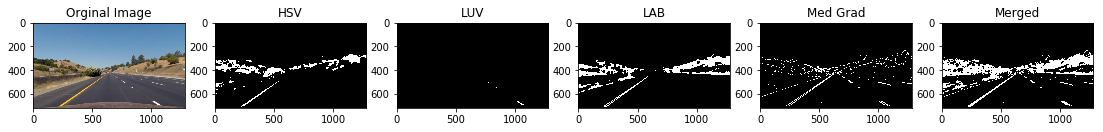

Lane width:  348.079774357
Radius:      12519.075369
Car Dist:    0.283468079067


<Figure size 1368x576 with 0 Axes>

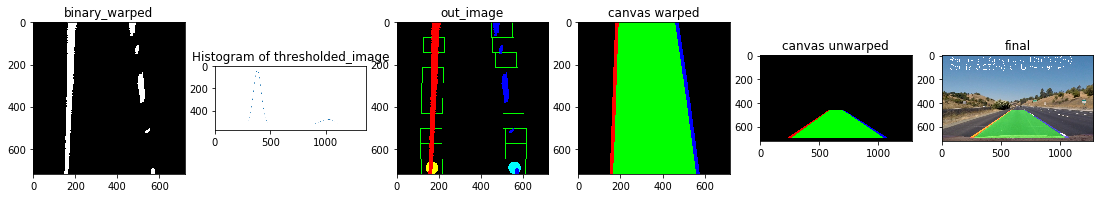

In [7]:
import glob

for img_fname in glob.glob(data_base_dir + "/test_images/straight_lines1.jpg"):
#for img_fname in glob.glob(data_base_dir + "/test_images/*.jpg"):
#for img_fname in glob.glob(data_base_dir + "/test_images/test1.jpg"):
#for img_fname in glob.glob("./challenge_video_frames/*.jpg"):
    print(img_fname)
    img = cv2.imread(img_fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lane_finding_pipeline(img, Frame(), visualize = True, log = True)

In [8]:
def process_video(imgFrame):
    global videoFrameObj
    global numberFrames
    
    videoFrameObj.verbose_log = True
    numberFrames += 1
    videoFrameObj.frameNum = numberFrames
    viz_cond = numberFrames >= 200 and numberFrames <= 500 and numberFrames % 5 == 0
    visualize = True if (viz_cond) else False
    visualize = False
    
    if visualize:
        print("\n\n", numberFrames)
        videoFrameObj.verbose_log = True
    else:
        videoFrameObj.verbose_log = False
    try:
        return lane_finding_pipeline(imgFrame, videoFrameObj, visualize = visualize)
    except Exception as e:
        print("#" * 10, numberFrames, str(e), "#" * 10)
        raise Exception(e)
        # return imgFrame

In [9]:
videoFrameObj = Frame()
numberFrames = -1

#input_fileName = data_base_dir + "/test_videos/project_video_clipped.mp4"
input_fileName = data_base_dir + "/test_videos/project_video.mp4"

video = VideoFileClip(input_fileName, audio = False)
processed_video = video.fl_image(process_video)

#output_fileName = output_base_dir + "/output_videos/project_video_clipped.mp4"
output_fileName = output_base_dir + "/output_videos/project_video.mp4"
% time processed_video.write_videofile(output_fileName, audio = False)

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_fileName))

[MoviePy] >>>> Building video ./output/output_videos/project_video.mp4
[MoviePy] Writing video ./output/output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [01:43<00:00, 12.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/output_videos/project_video.mp4 

CPU times: user 5min 6s, sys: 1min 24s, total: 6min 30s
Wall time: 1min 44s


videoFrameObj = Frame()
numberFrames = -1

input_fileName = data_base_dir + "/challenge_videos/challenge_video.mp4"

video = VideoFileClip(input_fileName, audio = False)
processed_video = video.fl_image(process_video)

output_fileName = output_base_dir + "/output_videos/challenge_video.mp4"
% time processed_video.write_videofile(output_fileName, audio = False)

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_fileName))

videoFrameObj = Frame()
numberFrames = -1

input_fileName = data_base_dir + "/challenge_videos/harder_challenge_video.mp4"

video = VideoFileClip(input_fileName, audio = False)
processed_video = video.fl_image(process_video)

output_fileName = output_base_dir + "/output_videos/harder_challenge_video.mp4"
% time processed_video.write_videofile(output_fileName, audio = False)

from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_fileName))


Yellow color in
RGB 255, 255, 0
HSV 60', 100%, 100%
HLS 60', 50%, 100%
    
color and gradient thresholding is used to find lane lines
one the image is converting into binary using aforementioned techniques

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. Here we want bird eye view

A perspective transform changes the perspective of objects in an image i.e. it either pushes them away or pull them closer. A birds eyes view is useful to find lane curvature so that lane lines that appears to meet each other at horizon would appear parellel in birds eye view

and then if they lane line are curving then the curve can be described using the equation ax^2 + bx + c for each lane line

we use perspective transform to get a birds eye view of the specific trapezoidal region which has lane information


